## Import Libraries

In [1]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

import plotly.express as px 

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

from sklearn.preprocessing import StandardScaler

%matplotlib inline

## Load the Data

In [2]:
df = pd.read_csv("cleaned/clean_data.csv")

In [3]:
df.info()
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10754 entries, 0 to 10753
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   team                 10754 non-null  object 
 1   name                 10754 non-null  object 
 2   position             10754 non-null  object 
 3   height               10754 non-null  float64
 4   age                  10754 non-null  float64
 5   appearance           10754 non-null  int64  
 6   goals                10754 non-null  float64
 7   assists              10754 non-null  float64
 8   yellow cards         10754 non-null  float64
 9   second yellow cards  10754 non-null  float64
 10  red cards            10754 non-null  float64
 11  goals conceded       10754 non-null  float64
 12  clean sheets         10754 non-null  float64
 13  minutes played       10754 non-null  int64  
 14  days_injured         10754 non-null  int64  
 15  games_injured        10754 non-null 

In [4]:
df["position_encoded"].value_counts()

position_encoded
2    3528
3    3095
4    2902
1    1229
Name: count, dtype: int64

In [5]:
df["position"].value_counts()

position
Defender Centre-Back          1821
Attack Centre-Forward         1353
Goalkeeper                    1229
midfield-CentralMidfield      1149
midfield-DefensiveMidfield     900
Defender Right-Back            867
Defender Left-Back             807
midfield-AttackingMidfield     769
Attack-RightWinger             717
Attack-LeftWinger              714
midfield-RightMidfield         102
midfield-LeftMidfield          100
midfield                        75
Attack-SecondStriker            65
Attack                          53
Defender                        33
Name: count, dtype: int64

In [6]:
df.head(2)

,team,name,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,Manchester United,David de Gea,Goalkeeper,189.0,32.0,104,0.0,0.0,0.009585,0.0,...,1.217252,0.335463,9390,42,5,13,15000000,70000000,1,0
1,Manchester United,Jack Butland,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,0.0,...,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [7]:
df[df.duplicated()]

,team,name,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger


In [8]:
df.dtypes

team                    object
name                    object
position                object
height                 float64
age                    float64
appearance               int64
goals                  float64
assists                float64
yellow cards           float64
second yellow cards    float64
red cards              float64
goals conceded         float64
clean sheets           float64
minutes played           int64
days_injured             int64
games_injured            int64
award                    int64
current_value            int64
highest_value            int64
position_encoded         int64
winger                   int64
dtype: object

In [9]:
# temp = {1: "Goalkeeper" , 2: "Defender", 3: "midfield", 4: "Attack"}
# df["position_encoded"] = df["position_encoded"].map(lambda x: temp[x])

In [10]:
df["position_encoded"]

0        1
1        1
2        1
3        2
4        2
        ..
10749    4
10750    4
10751    4
10752    4
10753    4
Name: position_encoded, Length: 10754, dtype: int64

In [11]:
# df = df.drop("position", axis=1)

In [12]:
# df = df.rename(columns={"position_encoded" : "position"})

In [13]:
df.dtypes

team                    object
name                    object
position                object
height                 float64
age                    float64
appearance               int64
goals                  float64
assists                float64
yellow cards           float64
second yellow cards    float64
red cards              float64
goals conceded         float64
clean sheets           float64
minutes played           int64
days_injured             int64
games_injured            int64
award                    int64
current_value            int64
highest_value            int64
position_encoded         int64
winger                   int64
dtype: object

In [14]:
# df.drop(, axis=1, inplace=True)

In [15]:
df.drop(["position","team","name"], axis=1, inplace=True)
# select features columns
categorical_features = list(df.select_dtypes(object).columns)
numeric_features = list(df.select_dtypes('number'))

# remove encoded columns


# removing this increased the r2 score but idk of this is luck (need more checking)
numeric_features.remove("highest_value")

# remove true value column
# categorical_features.remove('position_encoded')
# categorical_features.remove('team')

print(categorical_features)
print(numeric_features)

[]
['height', 'age', 'appearance', 'goals', 'assists', 'yellow cards', 'second yellow cards', 'red cards', 'goals conceded', 'clean sheets', 'minutes played', 'days_injured', 'games_injured', 'award', 'current_value', 'position_encoded', 'winger']


In [16]:
# categorical_features.remove('position')

In [17]:
for i in categorical_features:
    print (df[i].value_counts())

In [18]:
# all good for categorical data

In [19]:
# from our EDA we know that we have too many normal outliers


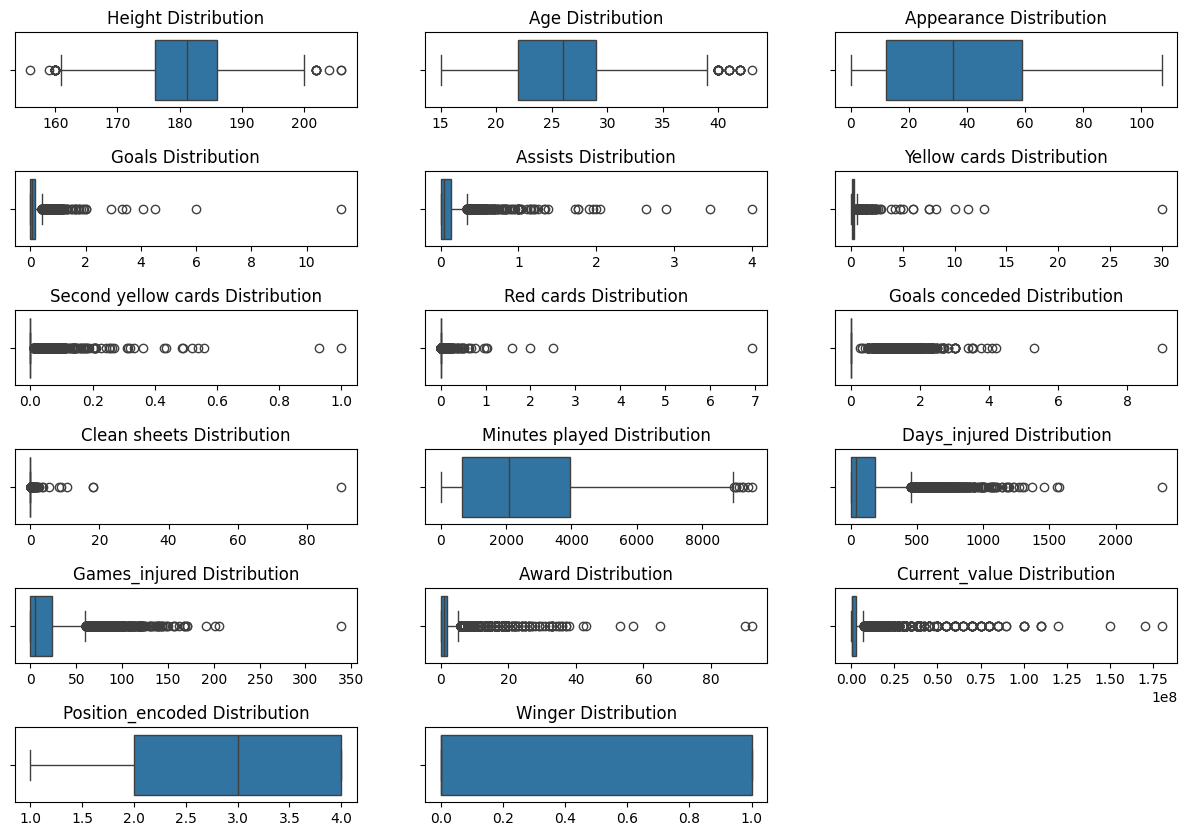

In [20]:
def plot_outliers(df: pd.DataFrame, features: list[str]) -> None:
    """
    Plots boxplots to show outliers for specified features in a DataFrame.
    
    param df: pd.DataFrame
    param features: list[str]
    
    return: None
    """
    # determine the number of rows needed for subplots
    n_rows: int = (len(features) + 2) // 3
    
    # create figure for subplots
    plt.figure(figsize=(15, 10))
    
    # plot each feature as a boxplot to show outliers
    for i, column in enumerate(features, 1):
        # add subplot
        plt.subplot(n_rows, 3, i)
        
        # create boxplot
        sns.boxplot(x=df[column])
        
        # set plot title and labels
        plt.title(f'{column.capitalize()} Distribution')
        plt.xlabel('')
        
        # add space between plots for clarity
        plt.subplots_adjust(hspace=0.85)
    
    # show plots
    plt.show()
    
plot_outliers(df, numeric_features)

In [21]:
# here we can see that there is many outliers and in our case 
# the Linear Regression is sensitive to outliers so we need a way to deal with the outlier, here are some:
# Z-Score
# IQR
# we will be using IQR

In [22]:
def remove_outliers_iqr(data: pd.DataFrame, columns: list[str]) -> pd.DataFrame:
    """
    Removes outliers from specified columns in a DataFrame using the IQR method.
    
    param data: pd.DataFrame
    param columns: list[str]
    
    return: pd.DataFrame
    """
    # iterate over each column to remove outliers
    for column in columns:
        # calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        
        # calculate IQR (Interquartile Range)
        IQR = Q3 - Q1
        
        # define lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # filter out outliers
        data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    
    return data

In [23]:
def remove_outliers_zscore(df: pd.DataFrame, columns: list[str], threshold: float = 3.0) -> pd.DataFrame:
    """
    Removes outliers from specified columns in a DataFrame using the Z-score method.
    
    param df: pd.DataFrame - The input data.
    param columns: list[str] - The list of columns to check for outliers.
    param threshold: float - The Z-score threshold for identifying outliers.
    
    return: pd.DataFrame - The DataFrame with outliers removed.
    """
    # calculate Z-scores
    z_scores = np.abs(df[columns].apply(zscore))

    # filter out outliers
    filtered_df = df[(z_scores < threshold).all(axis=1)]
    
    return filtered_df

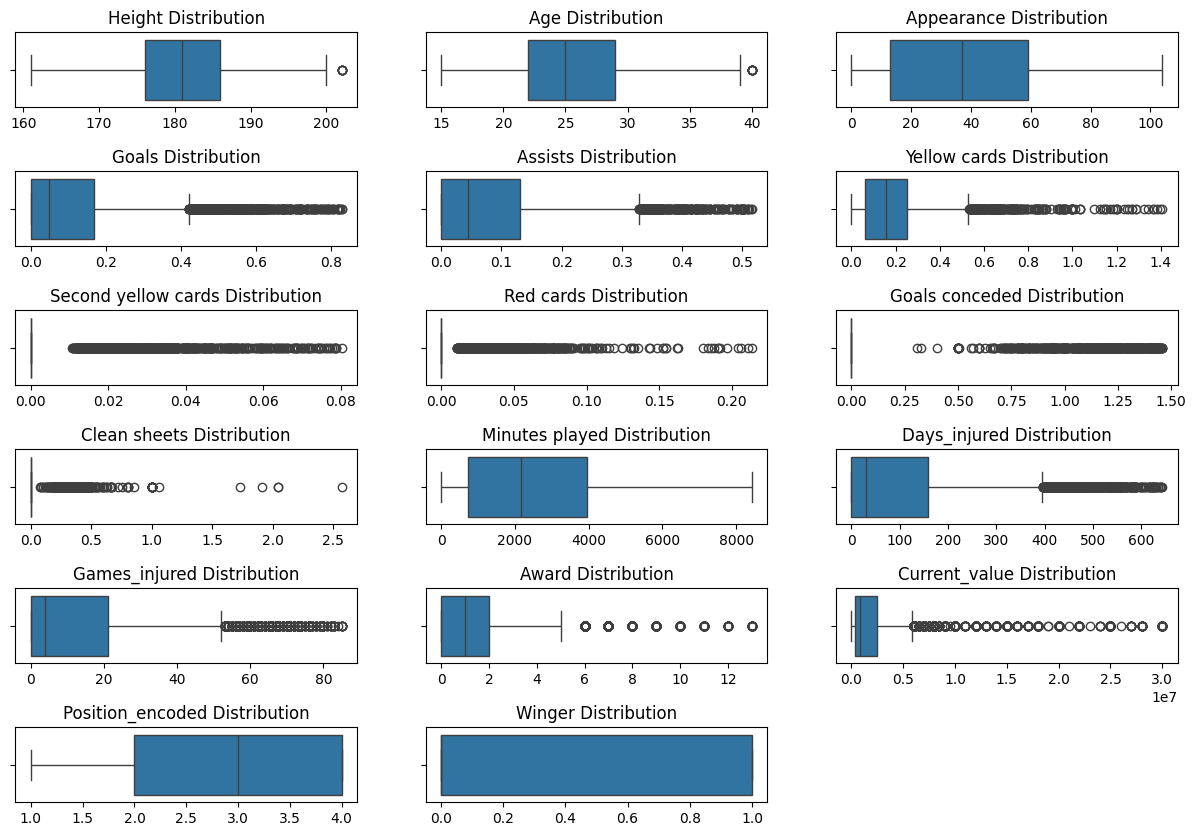

Original vs IQR: (10754, 18) vs (9369, 18) 


In [24]:
# filter outlier
filtered_data = remove_outliers_zscore(df, numeric_features, 3)

# plot to compare
plot_outliers(filtered_data, numeric_features)
print(f"Original vs IQR: {df.shape} vs {filtered_data.shape} ")

In [25]:
# here we can see that the outliers are better by visualization (some data are too small need check)

#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [26]:
# here we just change the df
# df = filtered_data.copy()

In [27]:
df.head(2)

,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,189.0,32.0,104,0.0,0.0,0.009585,0.0,0.0,1.217252,0.335463,9390,42,5,13,15000000,70000000,1,0
1,196.0,30.0,15,0.0,0.0,0.069018,0.0,0.0,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0


In [28]:
categorical_features

[]

In [29]:
# # one hot coding
# df = pd.get_dummies(df, columns=categorical_features)

In [30]:
df.columns

Index(['height', 'age', 'appearance', 'goals', 'assists', 'yellow cards',
       'second yellow cards', 'red cards', 'goals conceded', 'clean sheets',
       'minutes played', 'days_injured', 'games_injured', 'award',
       'current_value', 'highest_value', 'position_encoded', 'winger'],
      dtype='object')

In [31]:
display(df.head(2))
df.shape

,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,189.0,32.0,104,0.0,0.0,0.009585,0.0,0.0,1.217252,0.335463,9390,42,5,13,15000000,70000000,1,0
1,196.0,30.0,15,0.0,0.0,0.069018,0.0,0.0,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0


(10754, 18)

#### 3. Feature selection

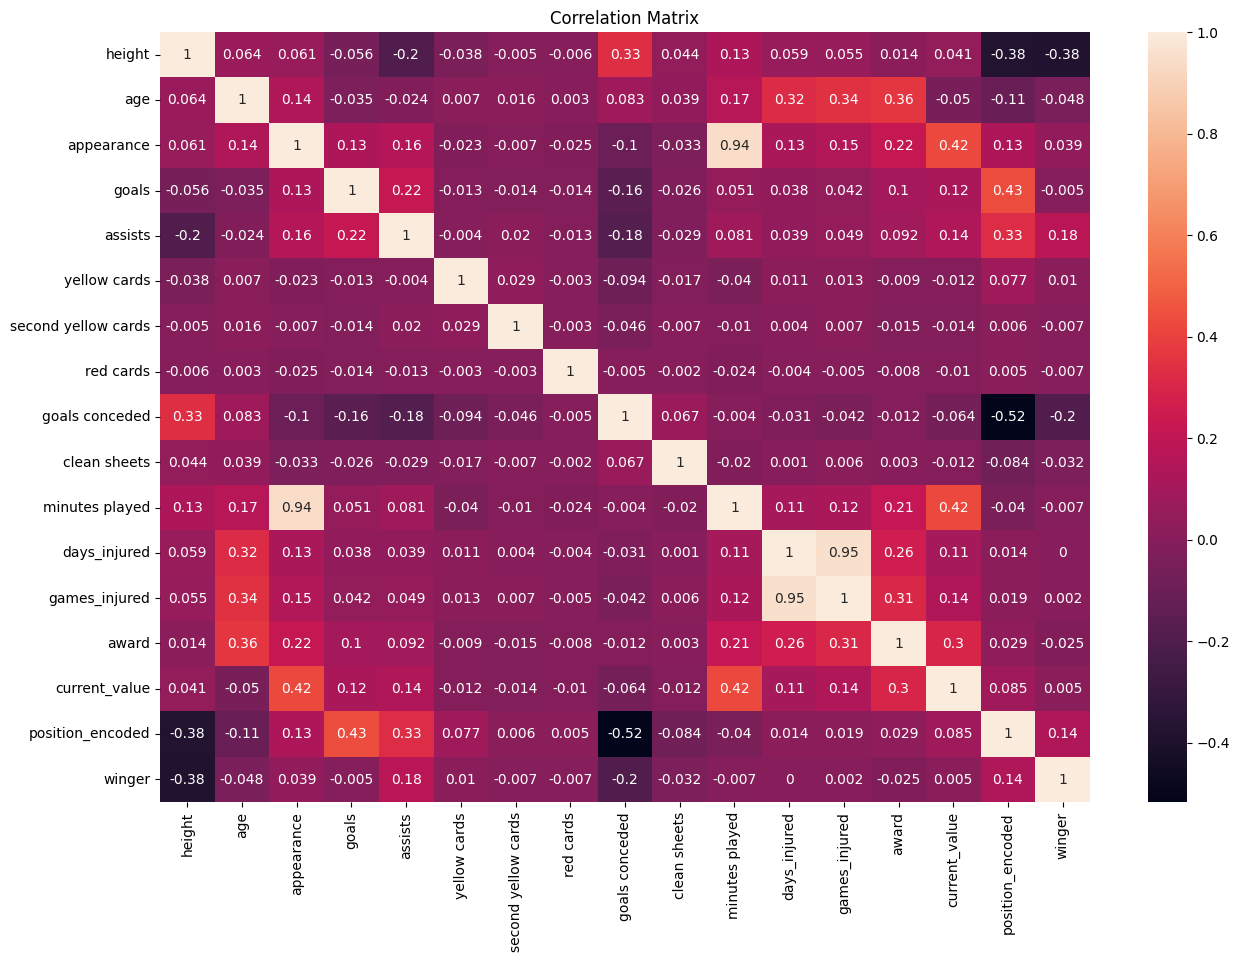

In [32]:
plt.figure(figsize=(15, 10))
sns.heatmap(round(df[numeric_features].corr(),3), annot=True)
plt.title('Correlation Matrix')
plt.show()

In [33]:
df.columns

Index(['height', 'age', 'appearance', 'goals', 'assists', 'yellow cards',
       'second yellow cards', 'red cards', 'goals conceded', 'clean sheets',
       'minutes played', 'days_injured', 'games_injured', 'award',
       'current_value', 'highest_value', 'position_encoded', 'winger'],
      dtype='object')

In [34]:
# encoder = LabelEncoder()
# df['position'] = encoder.fit_transform(df['position_encoded'])

In [35]:
df[numeric_features].head(2)

,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,position_encoded,winger
0,189.0,32.0,104,0.0,0.0,0.009585,0.0,0.0,1.217252,0.335463,9390,42,5,13,15000000,1,0
1,196.0,30.0,15,0.0,0.0,0.069018,0.0,0.0,1.242331,0.207055,1304,510,58,1,1500000,1,0


In [36]:
df.select_dtypes('number').dtypes

height                 float64
age                    float64
appearance               int64
goals                  float64
assists                float64
yellow cards           float64
second yellow cards    float64
red cards              float64
goals conceded         float64
clean sheets           float64
minutes played           int64
days_injured             int64
games_injured            int64
award                    int64
current_value            int64
highest_value            int64
position_encoded         int64
winger                   int64
dtype: object

In [37]:
df['position_encoded'].value_counts()

position_encoded
2    3528
3    3095
4    2902
1    1229
Name: count, dtype: int64

In [38]:
correlation = df.corr(numeric_only=True)
print(correlation['position_encoded'].sort_values(ascending=False))

position_encoded       1.000000
goals                  0.434600
assists                0.324714
winger                 0.144111
appearance             0.129357
highest_value          0.101053
current_value          0.085154
yellow cards           0.077185
award                  0.029111
games_injured          0.019375
days_injured           0.013889
second yellow cards    0.005766
red cards              0.004614
minutes played        -0.039969
clean sheets          -0.084334
age                   -0.107469
height                -0.378333
goals conceded        -0.517020
Name: position_encoded, dtype: float64


In [39]:
correlation

,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
height,1.000000,0.063652,0.060641,-0.055962,-0.202441,-0.037974,-0.005112,-0.005693,0.333092,0.044366,0.132887,0.059392,0.054902,0.013976,0.040535,0.036776,-0.378333,-0.381728
age,0.063652,1.000000,0.139846,-0.034805,-0.024156,0.007085,0.015529,0.003074,0.083343,0.039064,0.169020,0.324267,0.343029,0.363478,-0.050156,0.123468,-0.107469,-0.047808
appearance,0.060641,0.139846,1.000000,0.131469,0.157186,-0.023092,-0.007436,-0.024514,-0.101384,-0.032515,0.945365,0.127369,0.147528,0.222139,0.419656,0.418394,0.129357,0.038713
goals,-0.055962,-0.034805,0.131469,1.000000,0.218266,-0.012826,-0.013974,-0.013940,-0.158107,-0.025811,0.050863,0.037527,0.041696,0.099617,0.121574,0.129037,0.434600,-0.004581
assists,-0.202441,-0.024156,0.157186,0.218266,1.000000,-0.004430,0.019551,-0.013189,-0.180607,-0.029460,0.081136,0.039431,0.049383,0.091569,0.137415,0.145407,0.324714,0.177580
yellow cards,-0.037974,0.007085,-0.023092,-0.012826,-0.004430,1.000000,0.028739,-0.003007,-0.093675,-0.017122,-0.039652,0.011461,0.012892,-0.009052,-0.011766,-0.009772,0.077185,0.010097
second yellow cards,-0.005112,0.015529,-0.007436,-0.013974,0.019551,0.028739,1.000000,-0.002562,-0.045840,-0.006770,-0.010411,0.003772,0.007090,-0.015231,-0.013889,-0.014155,0.005766,-0.007259
red cards,-0.005693,0.003074,-0.024514,-0.013940,-0.013189,-0.003007,-0.002562,1.000000,-0.004584,-0.001778,-0.024402,-0.003650,-0.004764,-0.007886,-0.010171,-0.007257,0.004614,-0.007026
goals conceded,0.333092,0.083343,-0.101384,-0.158107,-0.180607,-0.093675,-0.045840,-0.004584,1.000000,0.067466,-0.004267,-0.030926,-0.042140,-0.011520,-0.063529,-0.061183,-0.517020,-0.198351
clean sheets,0.044366,0.039064,-0.032515,-0.025811,-0.029460,-0.017122,-0.006770,-0.001778,0.067466,1.000000,-0.020190,0.001275,0.005611,0.002996,-0.011684,-0.008302,-0.084334,-0.032354


In [40]:
# Set the correlation threshold
threshold = 0.03  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['position_encoded']) > threshold]['position_encoded'].index
selected_features

Index(['height', 'age', 'appearance', 'goals', 'assists', 'yellow cards',
       'goals conceded', 'clean sheets', 'minutes played', 'current_value',
       'highest_value', 'position_encoded', 'winger'],
      dtype='object')

In [41]:
df[selected_features]

,height,age,appearance,goals,assists,yellow cards,goals conceded,clean sheets,minutes played,current_value,highest_value,position_encoded,winger
0,189.000000,32.0,104,0.000000,0.000000,0.009585,1.217252,0.335463,9390,15000000,70000000,1,0
1,196.000000,30.0,15,0.000000,0.000000,0.069018,1.242331,0.207055,1304,1500000,22000000,1,0
2,188.000000,37.0,4,0.000000,0.000000,0.000000,0.616438,0.924658,292,600000,6000000,1,0
3,175.000000,25.0,82,0.028090,0.056180,0.224719,0.000000,0.000000,6408,50000000,50000000,2,0
4,191.000000,30.0,63,0.017889,0.017889,0.053667,0.000000,0.000000,5031,40000000,80000000,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10749,181.240353,20.0,16,0.175953,0.087977,0.263930,0.000000,0.000000,1023,75000,75000,4,1
10750,190.000000,24.0,26,0.372671,0.186335,0.186335,0.000000,0.000000,1449,300000,300000,4,0
10751,181.240353,19.0,20,0.375000,0.000000,0.187500,0.000000,0.000000,960,50000,50000,4,0
10752,181.240353,20.0,17,0.312139,0.104046,0.000000,0.000000,0.000000,865,50000,50000,4,0


#### 4. Prepare train and test data

In [42]:
# Prepare data
X = df[selected_features].drop(["position_encoded"], axis=1)

In [43]:
df.head(2)

,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,189.0,32.0,104,0.0,0.0,0.009585,0.0,0.0,1.217252,0.335463,9390,42,5,13,15000000,70000000,1,0
1,196.0,30.0,15,0.0,0.0,0.069018,0.0,0.0,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0


In [44]:
# scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [45]:
X_scaled.shape

(10754, 12)

## Buliding the Model

In [46]:
# 2. Use NearestNeighbors to find the optimal eps
min_samples = 2

In [47]:
nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(X_scaled)
distances, indices = nn.kneighbors(X_scaled)

In [48]:
distances[:,min_samples-1]

array([2.75908688, 1.02296098, 0.66028788, ..., 0.42591403, 0.3960414 ,
       0.47786397])

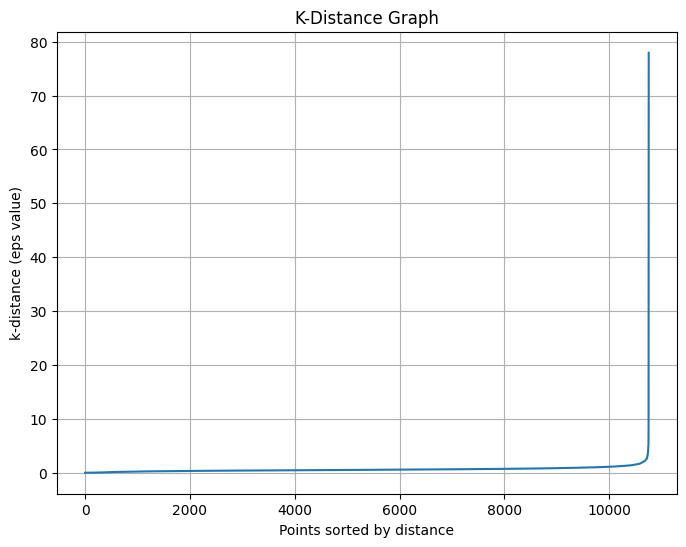

In [49]:
# The distance to the furthest neighbor (min_samples-th nearest) for each point
k_dist = distances[:, min_samples-1]

# Sort distances
k_dist_sorted = np.sort(k_dist)

# 3. Plotting the k-distance graph
plt.figure(figsize=(8, 6))
plt.plot(k_dist_sorted)
plt.title('K-Distance Graph')
plt.xlabel('Points sorted by distance')
plt.ylabel('k-distance (eps value)')
plt.grid(True)
plt.show()

In [50]:
# 4. Apply DBSCAN with chosen eps and min_samples
# Typically, you choose eps at the "elbow" point in this plot, where the slope changes significantly
chosen_eps = 0.4  # This is an example; choose this value based on the plot
dbscan = DBSCAN(eps=chosen_eps, min_samples=min_samples)

## Train and Test


In [51]:
# Fit the model on the training data

clusters = dbscan.fit_predict(X_scaled)

In [52]:
pd.Series(clusters).value_counts()

-1      7767
 10     1132
 13      350
 90       38
 4        37
        ... 
 265       2
 71        2
 0         2
 261       2
 262       2
Name: count, Length: 527, dtype: int64

## Evaluating the Model 

In [53]:
silhouette_avg = silhouette_score(X, clusters)
silhouette_avg

-0.8873287081735642

In [54]:
X.head(2)

,height,age,appearance,goals,assists,yellow cards,goals conceded,clean sheets,minutes played,current_value,highest_value,winger
0,189.0,32.0,104,0.0,0.0,0.009585,1.217252,0.335463,9390,15000000,70000000,0
1,196.0,30.0,15,0.0,0.0,0.069018,1.242331,0.207055,1304,1500000,22000000,0


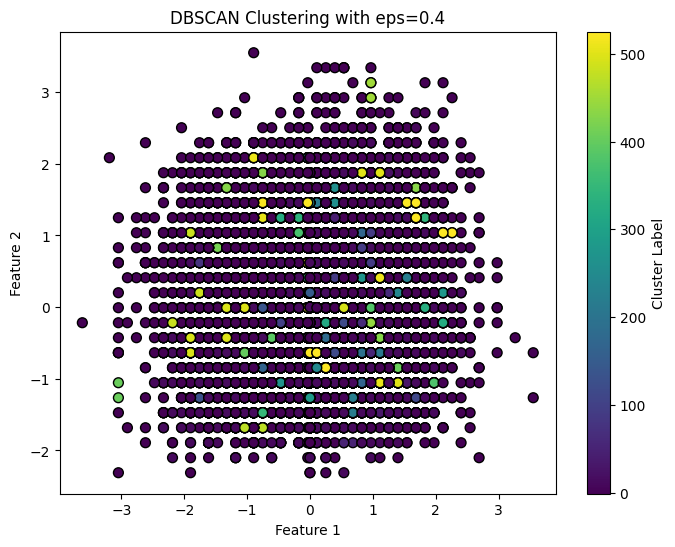

In [55]:
# 5. Plot the clustering result
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis', s=50, edgecolor='k')
plt.title(f'DBSCAN Clustering with eps={chosen_eps}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [56]:
X['dbscan'] = clusters

In [57]:
X['dbscan'].value_counts()

dbscan
-1      7767
 10     1132
 13      350
 90       38
 4        37
        ... 
 265       2
 71        2
 0         2
 261       2
 262       2
Name: count, Length: 527, dtype: int64

<Axes: xlabel='appearance', ylabel='age'>

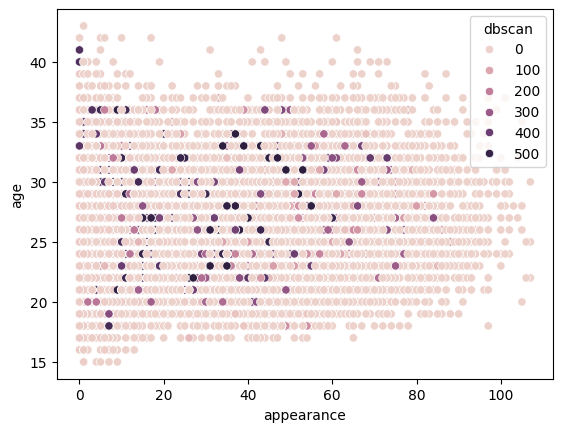

In [59]:
sns.scatterplot(data = X , y = 'age', x = 'appearance', hue = 'dbscan')

In [60]:
X.head(2)

,height,age,appearance,goals,assists,yellow cards,goals conceded,clean sheets,minutes played,current_value,highest_value,winger,dbscan
0,189.0,32.0,104,0.0,0.0,0.009585,1.217252,0.335463,9390,15000000,70000000,0,-1
1,196.0,30.0,15,0.0,0.0,0.069018,1.242331,0.207055,1304,1500000,22000000,0,-1


In [63]:
from sklearn.decomposition import PCA
kvalues = X["dbscan"]
pca_components = PCA(3).fit_transform(X.drop("dbscan", axis=1))


In [ ]:
pca_components.T.shape

(3, 10754)

In [ ]:
pca_df = pd.DataFrame(data={f'PCA{i+1}' : c for i, c in enumerate(pca_components.T)})
pca_df["kmeans"] = kvalues

In [ ]:

px.scatter_3d(pca_df.head(500), x="PCA1", y="PCA2", z="PCA3", color='kmeans' )